# Experimento 1

Basado en los notebooks proporcionados en los siguientes enlaces:


*   [pykan/.../tutorials/Example/Example_1_function_fitting](https://github.com/KindXiaoming/pykan/blob/master/tutorials/Example/Example_1_function_fitting.ipynb)
*   [pykan/hellokan.ipynb](https://github.com/KindXiaoming/pykan/blob/master/hellokan.ipynb)



El teorema de representación de Kolmogorov-Arnold establece que si $f$ es una función continua multivariada en un dominio acotado, entonces se puede escribir como una composición finita de funciones continuas de una sola variable y la operación binaria de suma.

Por lo tanto, dada $f : [0,1]^n \to \mathbb{R}$ cumpliendo ciertas condiciones,


 $$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

 donde $\phi_{q,p}:[0,1]\to\mathbb{R}$ y $\Phi_q:\mathbb{R}\to\mathbb{R}$.

 En cierto sentido, el KART indica que la única operación multivariada verdadera es la operación suma, ya que cualquier otra función puede escribirse usando funciones univariadas y la suma.

 Sin embargo, esta representación de Kolmogorov-Arnold de 2 capas de ancho $(2n+1)$ puede no ser suave debido a su limitada capacidad expresiva.

 En liu et al. (2024) se aumenta su capacidad expresiva generalizándola a profundidades y anchos arbitrarios.


## Instalación de pykan

In [1]:
!pip install pykan

  Using cached pykan-0.2.8-py3-none-any.whl.metadata (11 kB)
Using cached pykan-0.2.8-py3-none-any.whl (78 kB)


In [5]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


## Configuración de torch, device y generación de modelo base

In [7]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

cuda
checkpoint directory created: ./model
saving model version 0.0


## Creación del dataset

Se genera un conjunto de datos conformado con las evaluaciones de una función en una serie de valores de sus variables de entrada. La función create_dataset nos genera un conjunto de 1000 valores de entrenamiento y de etiquetas de entrenamiento asociadas.

In [8]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

## Inicialización del modelo

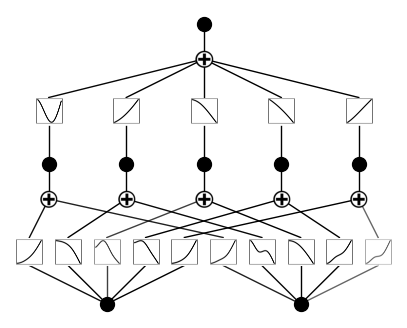

In [9]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot()

## Entrenamiento inicial

In [10]:
# train the model
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 1.91e-02 | test_loss: 1.88e-02 | reg: 5.74e+00 | : 100%|█| 50/50 [00:18<00:00,  2.77it

saving model version 0.1


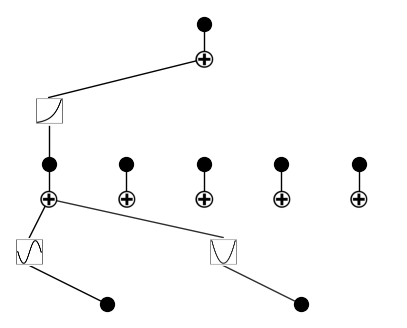

In [11]:
model.plot()

## Poda del modelo

saving model version 0.2


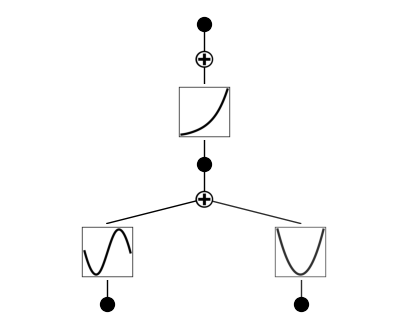

In [12]:
model = model.prune()
model.plot()

## Entrenamiento modelo podado

In [13]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.78e-02 | test_loss: 1.70e-02 | reg: 8.13e+00 | : 100%|█| 50/50 [00:12<00:00,  3.97it

saving model version 0.3


## Refinamos el grid del modelo

In [14]:
model = model.refine(10)

saving model version 0.4


## Entrenamiento modelo refinado

In [15]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 4.65e-04 | test_loss: 4.71e-04 | reg: 8.13e+00 | : 100%|█| 50/50 [00:12<00:00,  4.12it

saving model version 0.5


## Obtención de la expresión simbólica

In [16]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999999193565677, c=2
fixing (0,1,0) with x^2, r2=0.9999999823307842, c=2
fixing (1,0,0) with exp, r2=0.9999999908846936, c=2
saving model version 0.6


## Último entrenamiento para conseguir precisión máquina

In [17]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 9.41e-12 | test_loss: 3.70e-12 | reg: 0.00e+00 | : 100%|█| 50/50 [00:04<00:00, 11.42it

saving model version 0.7


## Expresión final redondeada

In [18]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

1.0*exp(1.0*x_2**2 + 1.0*sin(3.1416*x_1))

# Ejemplo nuevo

In [55]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,2,1,1], grid=3, k=3, seed=1, device=device)
f = lambda x: torch.exp((torch.cos(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.cos(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset(f, n_var=4, train_num=3000, device=device)

# train the model
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.002, lamb_entropy=2.);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.36e-01 | test_loss: 3.43e-01 | reg: 1.00e+01 | : 100%|█| 20/20 [00:45<00:00,  2.26s/

saving model version 0.1


In [56]:
model = model.prune(edge_th=1e-2)

saving model version 0.2


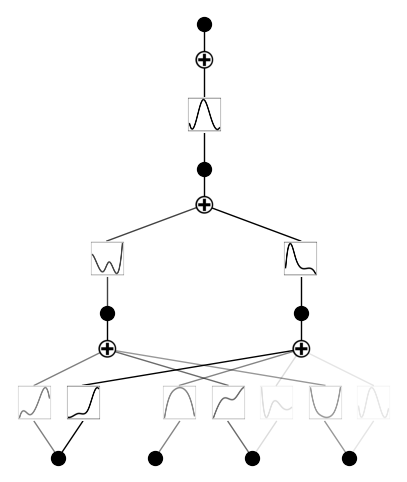

In [57]:
model.plot()

In [58]:
#grids = [3,5,10,20,50]
grids = [3,5,10,15]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    #model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0, device=device).initialize_from_another_model(model, dataset['train_input'])
    model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=50, stop_grid_update_step=20);
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

saving model version 0.3


| train_loss: 3.35e-01 | test_loss: 3.41e-01 | reg: 1.05e+01 | : 100%|█| 50/50 [01:25<00:00,  1.71s/


saving model version 0.4
saving model version 0.5


| train_loss: 3.12e-01 | test_loss: 3.33e-01 | reg: 1.05e+01 | : 100%|█| 50/50 [01:24<00:00,  1.69s/


saving model version 0.6
saving model version 0.7


| train_loss: 2.47e-01 | test_loss: 2.83e-01 | reg: 1.07e+01 | : 100%|█| 50/50 [01:24<00:00,  1.69s/


saving model version 0.8
saving model version 0.9


| train_loss: 2.17e-01 | test_loss: 2.72e-01 | reg: 1.08e+01 | : 100%|█| 50/50 [01:24<00:00,  1.68s/

saving model version 0.10


[0.33491458047828593, 0.3116140012454979, 0.24746186911760043, 0.21699923177666086]
[0.3414907763028715, 0.33281905966089087, 0.2830321329057478, 0.2716074918380671]


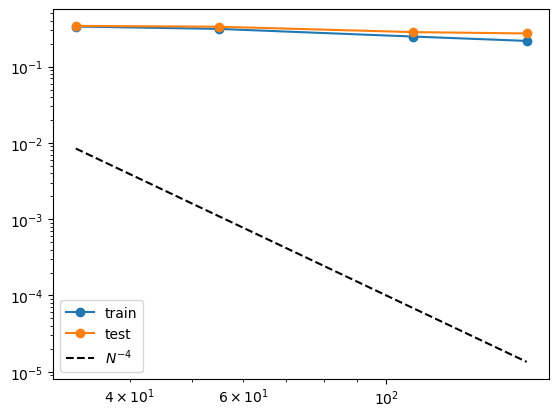

In [59]:
import numpy as np
import matplotlib.pyplot as plt

n_params = np.array(grids) * (4*2+2*1+1*1)
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 10000*n_params**(-4.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)

In [60]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs','cos']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.6891954583003471, c=1
fixing (0,0,1) with x, r2=0.7672119687592164, c=1
fixing (0,1,0) with 0
fixing (0,1,1) with x, r2=0.0006527763190471485, c=1
fixing (0,2,0) with x, r2=0.6124331171113655, c=1
fixing (0,2,1) with x, r2=0.015671232694491295, c=1
fixing (0,3,0) with cos, r2=0.9832471704704203, c=2
fixing (0,3,1) with x, r2=0.0013693399691198577, c=1
fixing (1,0,0) with cos, r2=0.9603408213760777, c=2
fixing (1,1,0) with x, r2=0.868049689484838, c=1
fixing (2,0,0) with x, r2=0.008799896389810453, c=1
saving model version 0.11


In [61]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

0.0613*x_1 - 0.0005*x_2 + 0.0003*x_3 - 0.0204*cos(2.0762*x_1 + 2.1578*x_3 - 57.4923*cos(0.348*x_4 - 0.0036) + 61.6549) + 1.0277

# Ejemplo original

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,2,1,1], grid=3, k=3, seed=1, device=device)
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset(f, n_var=4, train_num=3000, device=device)

# train the model
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.002, lamb_entropy=2.);

cuda
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.26e-01 | test_loss: 4.27e-01 | reg: 8.74e+00 | : 100%|█| 20/20 [00:43<00:00,  2.20s/

saving model version 0.1


In [70]:
model = model.prune(edge_th=1e-2)

saving model version 0.2


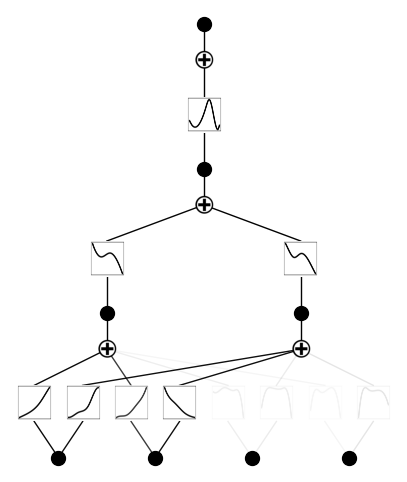

In [71]:
model.plot()

In [72]:
#grids = [3,5,10,20,50]
grids = [3,5,10]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    #model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0, device=device).initialize_from_another_model(model, dataset['train_input'])
    model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=50, stop_grid_update_step=20);
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

saving model version 0.3


| train_loss: 4.23e-01 | test_loss: 4.24e-01 | reg: 8.22e+00 | : 100%|█| 50/50 [01:25<00:00,  1.71s/


saving model version 0.4
saving model version 0.5


| train_loss: 4.01e-01 | test_loss: 4.08e-01 | reg: 8.33e+00 | : 100%|█| 50/50 [01:24<00:00,  1.70s/


saving model version 0.6
saving model version 0.7


| train_loss: 3.68e-01 | test_loss: 3.80e-01 | reg: 8.45e+00 | : 100%|█| 50/50 [01:26<00:00,  1.73s/

saving model version 0.8


[0.42297619651864254, 0.4005417137509311, 0.3684852027100266]
[0.4237151088255174, 0.4075801067759189, 0.379715286736203]


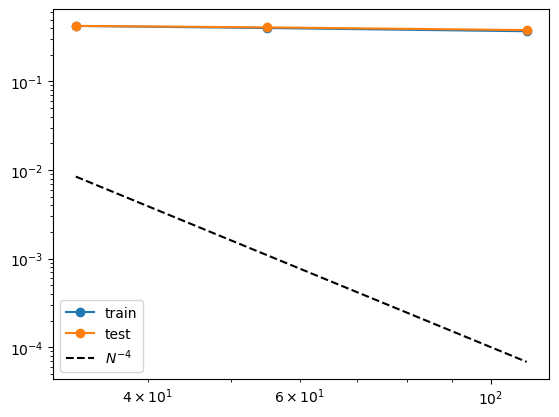

In [73]:
import numpy as np
import matplotlib.pyplot as plt

n_params = np.array(grids) * (4*2+2*1+1*1)
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 10000*n_params**(-4.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)

In [74]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs','cos']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.8741667131630695, c=1
fixing (0,0,1) with x, r2=0.7515288706329102, c=1
fixing (0,1,0) with exp, r2=0.9716346801112927, c=2
fixing (0,1,1) with x, r2=0.9799595525231799, c=1
fixing (0,2,0) with x^2, r2=0.9518431525017247, c=2
fixing (0,2,1) with x, r2=0.003343921618588383, c=1
fixing (0,3,0) with x, r2=0.00032781481554648647, c=1
fixing (0,3,1) with x, r2=0.029609760608970522, c=1
fixing (1,0,0) with x, r2=0.35353241247922423, c=1
fixing (1,1,0) with x, r2=0.40144748124366864, c=1
fixing (2,0,0) with x, r2=0.0034035748291901505, c=1
saving model version 0.9


In [75]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

-0.0262*x_1 + 0.0184*x_2 + 0.0001*x_4 + 0.0008*(-x_3 - 0.0303)**2 - 0.0001*exp(4.0236*x_2) + 1.5496